# Assignment-1
## Team: Aditya Ahuja (2020275), Deeptanshu Barman Chowdhuri (2020293)

##  Imports & Dataset

In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import random_split
import lightning as L
import matplotlib.pyplot as plt
import torchmetrics

C:\Users\Deeptanshu Barman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu"


In [4]:
Noise_0_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_syn_train_0_0_.csv"
)
Noise_Low_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_train_shuffled.csv"
)
Noise_High_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_test_hard_shuffled_sample.csv"
)

if Noise_0_data.status_code == 200 and Noise_Low_data.status_code == 200 and Noise_High_data.status_code == 200:
    datafolder = "Data/Assignment1"

    if not os.path.exists(datafolder):
        os.makedirs(datafolder)

    with open(os.path.join(datafolder, "data_0_noise"), "wb") as f:
        f.write(Noise_0_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_Low_noise"), "wb") as f:
        f.write(Noise_Low_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_High_noise"), "wb") as f:
        f.write(Noise_High_data.text.encode("utf-8"))
else:
    print("Error in fetching data")

In [3]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [4]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
class_index_t10v_noise = list(Noise_Low_dataframe["target_10_val"].unique())

def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

def encode_noise_t10v(value, class_index = class_index_t10v_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["target_10_val"] = Noise_Low_dataframe["target_10_val"].apply(encode_noise_t10v)
Noise_High_dataframe["target_10_val"] = Noise_High_dataframe["target_10_val"].apply(encode_noise_t10v)

## Setting up Dataset & Dataloaders

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None, target=None, drop=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [6]:
#Setting up datasets
Noise_0_dataset_era = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"], target = "era")
Noise_Low_dataset_era = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_High_dataset_era = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "era")
Noise_Low_dataset_t10v = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_High_dataset_t10v = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"], target = "target_10_val")
Noise_0_train_era, Noise_0_test_era = random_split(Noise_0_dataset_era, [int(len(Noise_0_dataset_era)*0.8), int(len(Noise_0_dataset_era)*0.2)])
Noise_Low_train_era, Noise_Low_test_era = random_split(Noise_Low_dataset_era, [int(len(Noise_Low_dataset_era)*0.8), int(len(Noise_Low_dataset_era)*0.2)])
Noise_High_train_era, Noise_High_test_era = random_split(Noise_High_dataset_era, [int(len(Noise_High_dataset_era)*0.8), int(len(Noise_High_dataset_era)*0.2)])
Noise_Low_train_t10v, Noise_Low_test_t10v = random_split(Noise_Low_dataset_t10v, [int(len(Noise_Low_dataset_t10v)*0.8), int(len(Noise_Low_dataset_t10v)*0.2)])
Noise_High_train_t10v, Noise_High_test_t10v = random_split(Noise_High_dataset_t10v, [int(len(Noise_High_dataset_t10v)*0.8), int(len(Noise_High_dataset_t10v)*0.2)])

In [7]:
#Setting up dataloaders
Noise_0_era_train_loader = DataLoader(Noise_0_train_era, batch_size=64, shuffle=True)
Noise_0_era_test_loader = DataLoader(Noise_0_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_era_train_loader = DataLoader(Noise_Low_train_era, batch_size=64, shuffle=True)
Noise_Low_era_test_loader = DataLoader(Noise_Low_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_High_era_train_loader = DataLoader(Noise_High_train_era, batch_size=64, shuffle=True)
Noise_High_era_test_loader = DataLoader(Noise_High_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_t10v_train_loader = DataLoader(Noise_Low_train_t10v, batch_size=512, shuffle=True)
Noise_Low_t10v_test_loader = DataLoader(Noise_Low_test_t10v, batch_size=512, shuffle=True)
########################################################################################
Noise_High_t10v_train_loader = DataLoader(Noise_High_train_t10v, batch_size=512, shuffle=True)
Noise_High_t10v_test_loader = DataLoader(Noise_High_test_t10v, batch_size=512, shuffle=True)
########################################################################################


## Model

In [120]:
class MyMLP(torch.nn.Module):
    def __init__ (self, layers,activation = torch.nn.ReLU(), dropout = 0.5):
        super().__init__()
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.layers = []
        for i in range(len(linear)):
            if (i == len(linear)-1):
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)
                if (dropout!=0): self.layers.append(torch.nn.Dropout(dropout))
        self.layers = torch.nn.Sequential(*self.layers)
        self.temperature = torch.nn.Parameter(torch.ones(1))
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, X):          
        X = self.layers(X)
        X=X/torch.abs(self.temperature)
        X = self.softmax(X)
        return X

In [121]:
def expected_calibration_error(samples, true_labels, M=5):
    # uniform binning approach with M number of bins
    bin_boundaries = torch.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = torch.max(samples, dim=1)[0]
    # get predictions from confidences (positional in this case)
    predicted_label = torch.argmax(samples, dim=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label == true_labels

    ece = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = torch.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.float().mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].float().mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece.item()

In [122]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            ece=expected_calibration_error(outputs,labels)
            loss = criterion(outputs, labels)+ece
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/50], Train Loss: 1.4648, Train Acc: 0.4699, Val Loss: 0.8303, Val Acc: 0.7000
Epoch [2/50], Train Loss: 0.7266, Train Acc: 0.7208, Val Loss: 0.6608, Val Acc: 0.7699
Epoch [3/50], Train Loss: 0.6051, Train Acc: 0.7628, Val Loss: 0.5565, Val Acc: 0.7788
Epoch [4/50], Train Loss: 0.5058, Train Acc: 0.8022, Val Loss: 0.4653, Val Acc: 0.8160
Epoch [5/50], Train Loss: 0.4458, Train Acc: 0.8247, Val Loss: 0.4680, Val Acc: 0.8218
Epoch [6/50], Train Loss: 0.4096, Train Acc: 0.8421, Val Loss: 0.3933, Val Acc: 0.8487
Epoch [7/50], Train Loss: 0.4132, Train Acc: 0.8399, Val Loss: 0.3716, Val Acc: 0.8513
Epoch [8/50], Train Loss: 0.3403, Train Acc: 0.8699, Val Loss: 0.4143, Val Acc: 0.8372
Epoch [9/50], Train Loss

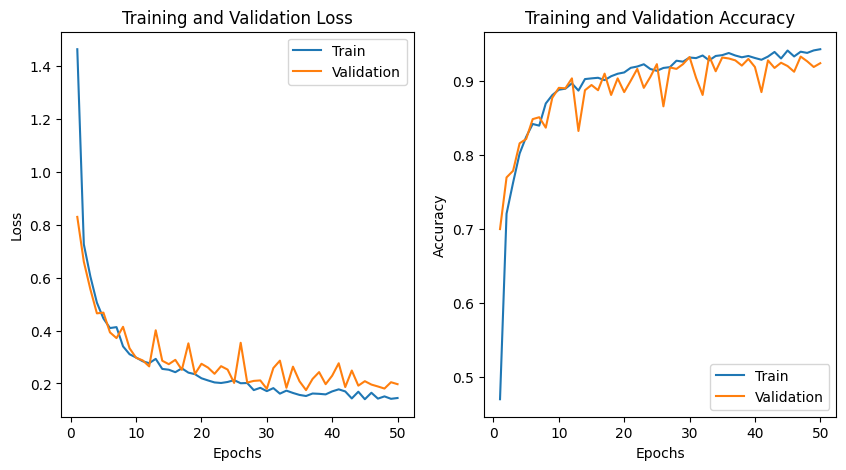

In [123]:
Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
Model = Model.to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
train_model(Model,torch.nn.CrossEntropyLoss(), optimizer,Noise_0_era_train_loader, Noise_0_era_test_loader,num_epochs=50)

In [124]:
Model.temperature.item()

1.0

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch

def binarize(target, c):
    return np.array([1 if t == c else 0 for t in target])

def plot_calibration_curve(Model,cls,test_loader):
    Model.eval()  # Set model to evaluation mode
    y_true = []
    y_probabilities = []

    # Iterate over test_loader to get predictions and true labels
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

        # Forward pass
        outputs = Model(inputs)
        probabilities = outputs
        y_true.extend(labels.cpu().numpy())  # Collect true labels
        y_probabilities.extend(probabilities[:, cls].detach().cpu().numpy())  # Collect probabilities for class 0

    y_true_binarized = binarize(y_true, cls)

    # print(len(y_true_binarized))
    # print(len(y_probabilities))
    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true_binarized,np.exp(y_probabilities), n_bins=10)
    print(prob_pred)
    # Plot calibration curve
    plt.plot(prob_pred, prob_true, marker='o', label="Class")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly Calibrated")
    plt.xlabel("Confidence")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve")
    plt.legend()
    plt.show()

[0.0017611  0.26862942 0.50500097 0.72632624 0.93596486]


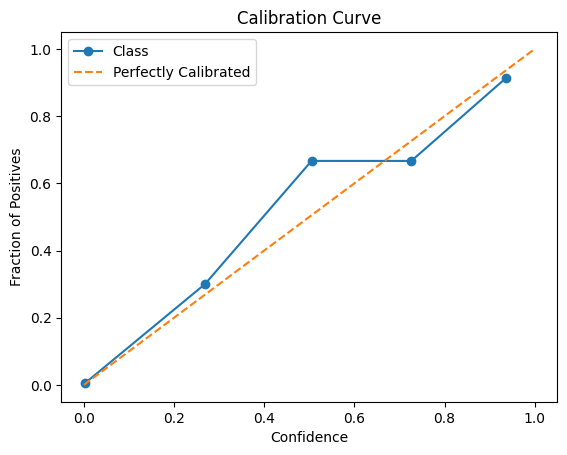

In [114]:
#only temperature
plot_calibration_curve(Model,cls=5,test_loader=Noise_0_era_test_loader)

[0.00376908 0.28012022 0.5330289  0.70071294 0.92361218]


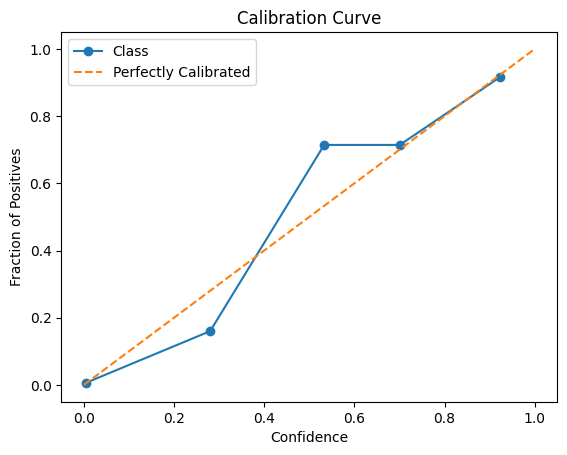

In [118]:
#temperature+ ece
plot_calibration_curve(Model,cls=5,test_loader=Noise_0_era_test_loader)

[0.00523852 0.30274471 0.47640928 0.71198102 0.93989983]


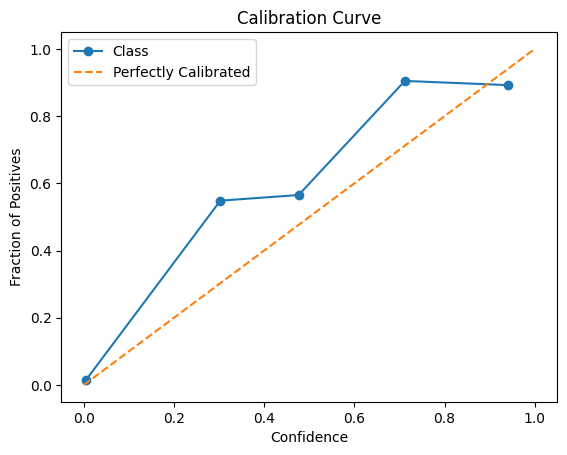

In [125]:
#simple Model
plot_calibration_curve(Model,cls=5,test_loader=Noise_0_era_test_loader)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 0.8229, Train Acc: 0.6688, Val Loss: 0.6799, Val Acc: 0.7248
Epoch [2/20], Train Loss: 0.6617, Train Acc: 0.7300, Val Loss: 0.6408, Val Acc: 0.7320
Epoch [3/20], Train Loss: 0.6240, Train Acc: 0.7441, Val Loss: 0.6515, Val Acc: 0.7334
Epoch [4/20], Train Loss: 0.6017, Train Acc: 0.7527, Val Loss: 0.5777, Val Acc: 0.7657
Epoch [5/20], Train Loss: 0.5880, Train Acc: 0.7591, Val Loss: 0.5873, Val Acc: 0.7550
Epoch [6/20], Train Loss: 0.5742, Train Acc: 0.7635, Val Loss: 0.5680, Val Acc: 0.7657
Epoch [7/20], Train Loss: 0.5683, Train Acc: 0.7670, Val Loss: 0.5749, Val Acc: 0.7661
Epoch [8/20], Train Loss: 0.5613, Train Acc: 0.7689, Val Loss: 0.5672, Val Acc: 0.7692
Epoch [9/20], Train Loss

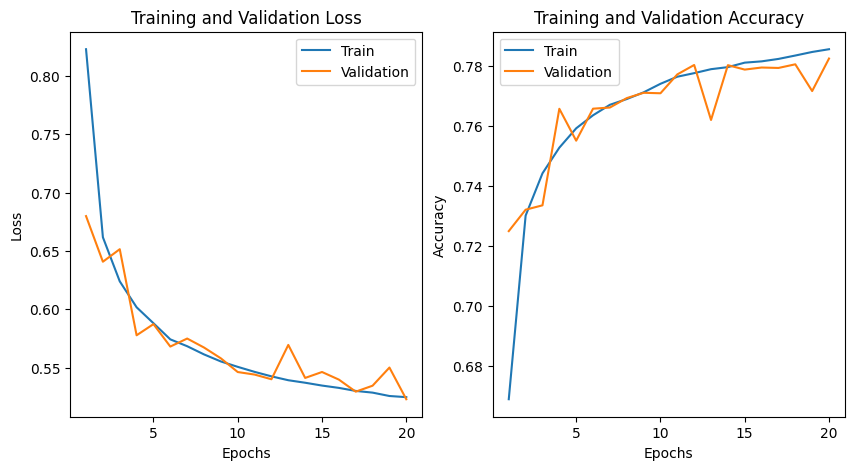

In [19]:
Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_Low_era_train_loader, Noise_Low_era_test_loader,num_epochs=20)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 1.4988, Train Acc: 0.4412, Val Loss: 1.3933, Val Acc: 0.4873
Epoch [2/20], Train Loss: 1.3653, Train Acc: 0.4862, Val Loss: 1.3610, Val Acc: 0.4855
Epoch [3/20], Train Loss: 1.3383, Train Acc: 0.4949, Val Loss: 1.3221, Val Acc: 0.4979
Epoch [4/20], Train Loss: 1.3261, Train Acc: 0.5000, Val Loss: 1.3095, Val Acc: 0.5092
Epoch [5/20], Train Loss: 1.3176, Train Acc: 0.5018, Val Loss: 1.3208, Val Acc: 0.5022
Epoch [6/20], Train Loss: 1.3110, Train Acc: 0.5045, Val Loss: 1.3435, Val Acc: 0.4901
Epoch [7/20], Train Loss: 1.3055, Train Acc: 0.5061, Val Loss: 1.3045, Val Acc: 0.5118
Epoch [8/20], Train Loss: 1.3018, Train Acc: 0.5072, Val Loss: 1.3130, Val Acc: 0.5020
Epoch [9/20], Train Loss

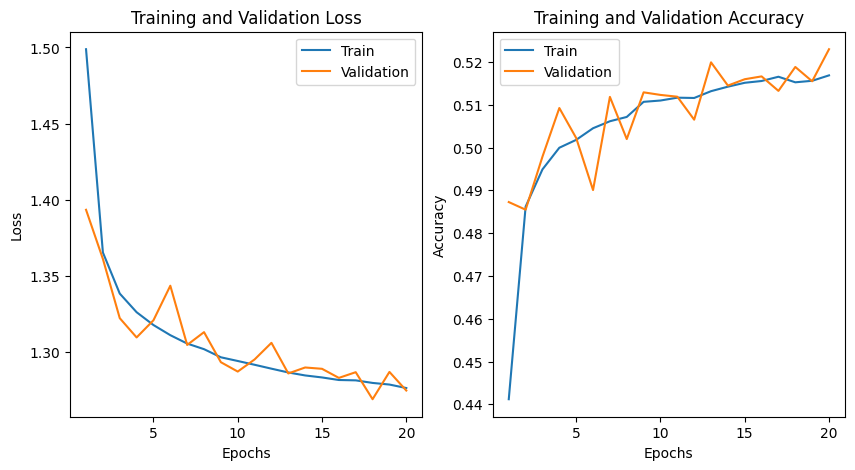

In [25]:
Model = MyMLP(layers = [24,64,32,12], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_High_era_train_loader, Noise_High_era_test_loader,num_epochs=20)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 0.6984, Train Acc: 0.7365, Val Loss: 0.5726, Val Acc: 0.7842
Epoch [2/20], Train Loss: 0.5517, Train Acc: 0.7899, Val Loss: 0.5281, Val Acc: 0.7990
Epoch [3/20], Train Loss: 0.5175, Train Acc: 0.8009, Val Loss: 0.5240, Val Acc: 0.7978
Epoch [4/20], Train Loss: 0.5019, Train Acc: 0.8072, Val Loss: 0.5068, Val Acc: 0.8016
Epoch [5/20], Train Loss: 0.4924, Train Acc: 0.8093, Val Loss: 0.4938, Val Acc: 0.8082
Epoch [6/20], Train Loss: 0.4851, Train Acc: 0.8112, Val Loss: 0.4827, Val Acc: 0.8134
Epoch [7/20], Train Loss: 0.4797, Train Acc: 0.8126, Val Loss: 0.4864, Val Acc: 0.8096
Epoch [8/20], Train Loss: 0.4739, Train Acc: 0.8153, Val Loss: 0.4846, Val Acc: 0.8093
Epoch [9/20], Train Loss:

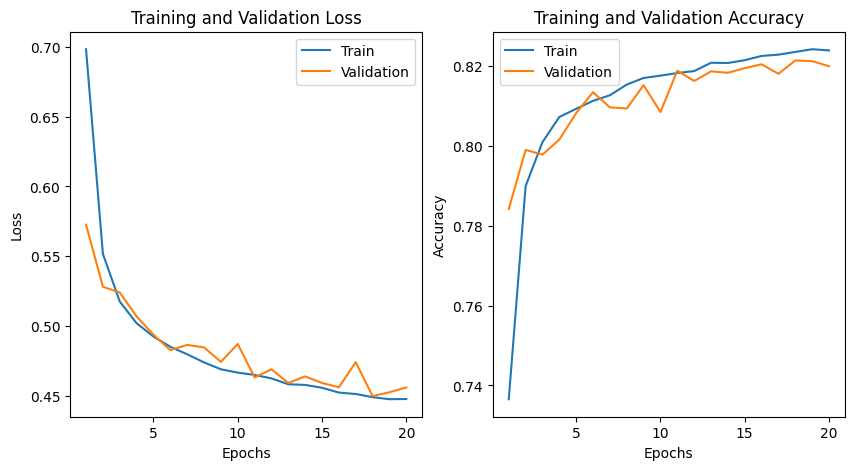

In [25]:
Model = MyMLP(layers = [24,64,32,5], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_Low_t10v_train_loader, Noise_Low_t10v_test_loader,num_epochs=20)

MyMLP(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (softmax): LogSoftmax(dim=1)
)
Epoch [1/20], Train Loss: 1.0336, Train Acc: 0.5718, Val Loss: 0.9469, Val Acc: 0.6124
Epoch [2/20], Train Loss: 0.9200, Train Acc: 0.6166, Val Loss: 0.9084, Val Acc: 0.6197
Epoch [3/20], Train Loss: 0.8917, Train Acc: 0.6266, Val Loss: 0.8900, Val Acc: 0.6264
Epoch [4/20], Train Loss: 0.8750, Train Acc: 0.6325, Val Loss: 0.8772, Val Acc: 0.6322
Epoch [5/20], Train Loss: 0.8626, Train Acc: 0.6360, Val Loss: 0.8684, Val Acc: 0.6352
Epoch [6/20], Train Loss: 0.8562, Train Acc: 0.6392, Val Loss: 0.8575, Val Acc: 0.6396
Epoch [7/20], Train Loss: 0.8501, Train Acc: 0.6408, Val Loss: 0.8579, Val Acc: 0.6367
Epoch [8/20], Train Loss: 0.8463, Train Acc: 0.6418, Val Loss: 0.8589, Val Acc: 0.6387
Epoch [9/20], Train Loss:

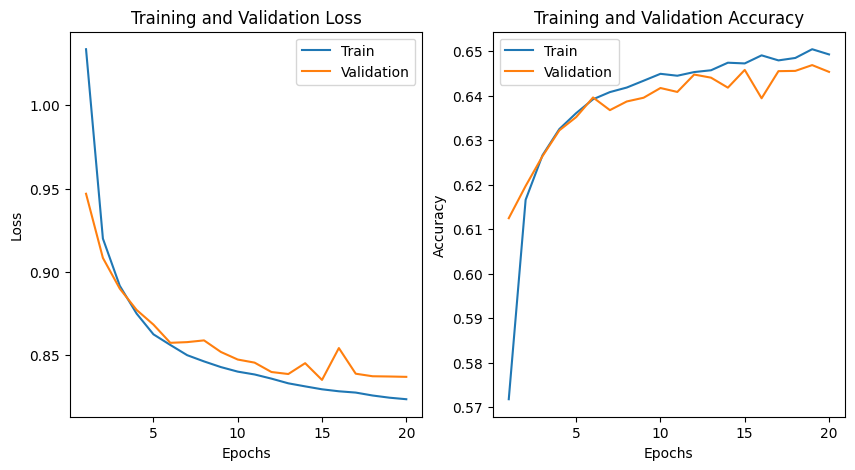

In [26]:
Model = MyMLP(layers = [24,64,32,5], dropout=0).to(device)
print(Model)
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01, weight_decay=0)
train_model(Model,torch.nn.NLLLoss(), optimizer,Noise_High_t10v_train_loader, Noise_High_t10v_test_loader,num_epochs=20)

In [ ]:
EnsembleModel = EnsembleClassifier(Noise_High_dataset_t10v, num_classifiers=8,num_classes=5)
EnsembleModel.train(torch.nn.NLLLoss(), 512, 5)